In [14]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
client = bigquery.Client()
from Predicting_Purchase_Intention.utils.get_data import get_raw_data
from Predicting_Purchase_Intention.utils.clean_data import drop_cols, clean_data
from sklearn.pipeline import Pipeline, make_pipeline 
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from xgboost import XGBClassifier


In [15]:
test_df = pd.read_csv('../raw_data/test_3days_dataset.csv')

In [1]:
test_df[test_df.target_variable > 0].shape[0]

NameError: name 'test_df' is not defined

In [44]:

test_df[test_df['first_visit & Home']>0].shape[0]

5478

In [ ]:
test_df[num].min(), test_df[num].max(), test_df[test_df[num]>0].shape[0])

In [6]:
test_df = test_df.fillna(0)

In [13]:
test_df.describe()

,Unnamed: 0,user_pseudo_id,add_payment_info & Payment Method,add_shipping_info & Checkout Your Information,add_shipping_info & Other,add_to_cart & Product Listing Page,begin_checkout & Checkout Your Information,begin_checkout & Other,click & Home,click & Information,...,view_promotion & New Product Listing Page,view_search_results & Search Results,visits_per_visitor,page_views,events_per_visitor,engagement_time_per_visitor,clicks,user_engagements,scrolls,target_variable
count,9827.000000,9.827000e+03,9827.00000,9827.000000,9827.000000,9827.000000,9827.000000,9827.000000,9827.000000,9827.000000,...,9827.000000,9827.000000,9827.000000,9827.000000,9827.000000,9.827000e+03,9827.000000,9827.000000,9827.000000,9827.000000
mean,4913.000000,2.683804e+08,0.04508,0.064618,0.000611,0.000407,0.064618,0.000611,0.000509,0.000305,...,0.000102,0.065330,1.832401,4.455378,14.504223,9.079290e+04,0.007632,3.932838,1.574438,1.360843
std,2836.954882,1.207053e+09,0.74263,0.705014,0.042796,0.040351,0.705014,0.042796,0.022552,0.017471,...,0.010088,0.388892,3.511560,13.030547,36.897003,7.656005e+05,0.111622,12.728720,4.220132,19.561409
min,0.000000,1.001569e+06,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,2456.500000,6.026782e+06,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,4.000000,2.599000e+03,0.000000,1.000000,0.000000,0.000000
50%,4913.000000,2.410443e+07,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,5.000000,1.266000e+04,0.000000,1.000000,1.000000,0.000000
75%,7369.500000,6.226668e+07,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.000000,3.000000,11.000000,5.164300e+04,0.000000,3.000000,1.000000,0.000000
max,9826.000000,9.657667e+09,47.00000,42.000000,4.000000,4.000000,42.000000,4.000000,1.000000,1.000000,...,1.000000,9.000000,153.000000,376.000000,1062.000000,7.079901e+07,4.000000,376.000000,150.000000,1054.000000


In [9]:
skewed_col=[]
categor_col = []
norm_col = []
for num in test_df.columns:
    if test_df[num].max() == 1 and test_df[num].min() == 0:
        categor_col.append(num)
    if test_df[num].median() > test_df[num].mean() or test_df[num].median() < test_df[num].mean():
        skewed_col.append(num)
    if test_df[num].median() == test_df[num].mean():
        norm_col.append(num)

In [20]:
# skewed_col

In [21]:
# categor_col

In [12]:
norm_col


['Unnamed: 0']

In [1]:
# for num in nu_df.columns:
#     print(num)

In [138]:
nu_df.isnull().sum().sort_values(ascending=False)/len(nu_df)

session_start & Payment Method               0.999898
add_to_cart & Product Listing Page           0.999898
view_item_list & New Product Listing Page    0.999898
view_promotion & New Product Listing Page    0.999898
click & Shopping Cart                        0.999898
                                               ...   
Unnamed: 0                                   0.000000
events_per_visitor                           0.000000
visits_per_visitor                           0.000000
user_pseudo_id                               0.000000
target_variable                              0.000000
Length: 112, dtype: float64

In [2]:
test_df = pd.read_csv('../raw_data/test_3days_dataset.csv')
#Use path specified on your branch

## Basic Preprocessing(To be expanded)

In [29]:
col_drop = []
for num in test_df.columns:
    if (test_df[num].isnull().sum()/len(test_df)*100) > 95:
        col_drop.append(num)

test_df = test_df.drop(columns =col_drop)
#drop columns with more than 95% missing values

list_y = list(set(test_df['target_variable'].values)) #unique values in the target variable
list_y.remove(0)
#dependent on what we eventually agree as the main class for the precision target
test_df['target_variable'] = test_df['target_variable'].replace(to_replace=list_y, value = -1) 
test_df['target_variable'] = test_df['target_variable'].replace(to_replace=0, value = 1)
test_df['target_variable'] = test_df['target_variable'].replace(to_replace=-1, value = 0)

In [84]:
#True Baseline
test_df['target_variable'].value_counts(normalize = True)

1    0.990129
0    0.009871
Name: target_variable, dtype: float64

❓ **Question (Imbalance)** ❓
Horrible imbalance in the dataset. Hence the need for a very high precision score at the micro level

In [17]:
X = test_df.drop(columns = ['target_variable', 'user_pseudo_id', 'Unnamed: 0'])
y = test_df['target_variable']
X.columns
num_list = ['first_visit & Home', 'first_visit & Product Listing Page',
       'page_view & Home', 'page_view & New Product Listing Page',
       'page_view & Other', 'page_view & Product Display Page',
       'page_view & Product Listing Page',
       'page_view & Sale Product Listing Page', 'page_view & Shopping Cart',
       'scroll & Home', 'scroll & Product Display Page',
       'scroll & Product Listing Page', 'scroll & Shopping Cart',
       'session_start & Home', 'session_start & Other',
       'session_start & Product Display Page',
       'session_start & Product Listing Page', 'user_engagement & Home',
       'user_engagement & New Product Listing Page', 'user_engagement & Other',
       'user_engagement & Product Display Page',
       'user_engagement & Product Listing Page',
       'user_engagement & Sale Product Listing Page',
       'user_engagement & Shopping Cart', 'view_item & Product Display Page',
       'view_item & Product Listing Page', 'view_promotion & Home',
       'visits_per_visitor', 'page_views', 'events_per_visitor',
       'engagement_time_per_visitor', 'user_engagements', 'scrolls']

In [18]:
X = test_df.drop(columns = ['target_variable', 'user_pseudo_id', 'Unnamed: 0'])
y = test_df['target_variable']

#basic Pipeline, can be improved once we insert categorical features 
num_transformer = make_pipeline(
    SimpleImputer(),
    MinMaxScaler())

preproc_baseline = make_column_transformer(
    (num_transformer, num_list),
    remainder = 'drop')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Modeling

❓ **Question (best models)** ❓

Attempting various models for the baseline: LinearSVC, KNC and Decision Tree Classifier. Based on our goals, we wants a very high score so that we can predict the a good base of customers who do not consummate their transactions and then target them with strategic advertisements. 

In [21]:
model1 = LinearSVC()
pipe_baseline = make_pipeline(preproc_baseline, model1)
pipe_baseline.fit(X_train,y_train)
scores = cross_validate(pipe_baseline, X_test, y_test, cv=5, scoring=['precision','f1'])


scores['test_f1'].mean(), scores['test_precision'].mean()

(0.9953946736730008, 0.9921803277614426)

In [44]:
model2 = KNeighborsClassifier(n_neighbors=2)
pipe_baseline = make_pipeline(preproc_baseline, model2)
pipe_baseline.fit(X_train,y_train)
scores = cross_validate(pipe_baseline, X_test, y_test, cv=5, scoring=['precision','f1'])


scores['test_f1'].mean(), scores['test_precision'].mean()

(0.9893189271792918, 0.994118747059121)

In [24]:
model3 = SVC()
pipe_baseline = make_pipeline(preproc_baseline, model3)
pipe_baseline.fit(X_train,y_train)
scores = cross_validate(pipe_baseline, X_test, y_test, cv=5, scoring=['precision','f1'])


scores['test_f1'].mean(), scores['test_precision'].mean()

(0.9954010644060822, 0.9908445800120859)

In [23]:
model4 = DecisionTreeClassifier()

pipe_baseline = make_pipeline(preproc_baseline, model4)
pipe_baseline.fit(X_train,y_train)
scores = cross_validate(pipe_baseline, X_test, y_test, cv=5, scoring=['precision','f1'])

scores['test_f1'].mean(), scores['test_precision'].mean()



(0.9928126115173939, 0.992812307017528)

❓ **Question (what to keep)** ❓
Let's expand on Linear SVC, KNC and DecisionTreeCLassifiers based on their better Precision Scores.
We will do a grid search for each and tweak the parameters. Afterwards, we can modify with XGboost


## Grid Search

In [85]:
model5 = KNeighborsClassifier()
pipe_baseline = make_pipeline(preproc_baseline, model5)

In [87]:
pipe_baseline.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('pipeline',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('minmaxscaler',
                                                     MinMaxScaler())]),
                                    ['first_visit & Home',
                                     'first_visit & Product Listing Page',
                                     'page_view & Home',
                                     'page_view & New Product Listing Page',
                                     'page_view & Other',
                                     'page_view & Product Display Page',
                                     'page_view & Product Listing Page',
                                     'page_view & Sale Product Listing Page',
                                     'pa...
                          

In [88]:
k_grid = {'kneighborsclassifier__n_neighbors' : [1,2,3,4,5,10,15,20,30,50]}
grid = GridSearchCV(pipe_baseline, k_grid, n_jobs=-1,  cv = 5, scoring='precision')
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         ['first_visit '
                                                                          '& '
                                                                          'Home',
                                                                          'first_visit '
                                                                          '& '
                                                                          'Product '
                                                                          'Listing '
                                                                          'Page',
                                                                          'page_view '
                                                                          '& '
                                                                          'Home',
                                                                          'page_view '
                                                                          '& '
                                                                          'New '
                                                                          'Product '
                                                                          'Listing '
                                                                          'Page',
                                                                          'page_view '
                                                                          '& '
                                                                          'Other',
                                                                          'page...
                                                                          'user_engagement '
                                                                          '& '
                                                                          'Shopping '
                                                                          'Cart',
                                                                          'view_item '
                                                                          '& '
                                                                          'Product '
                                                                          'Display '
                                                                          'Page',
                                                                          'view_item '
                                                                          '& '
                                                                          'Product '
                                                                          'Listing '
                                                                          'Page',
                                                                          'view_promotion '
                                                                          '& '
                                                                          'Home',
                                                                          'visits_per_visitor',
                                                                          'page_views',
                                           

In [89]:
grid.best_score_, grid.best_params_

(0.9942726858790414, {'kneighborsclassifier__n_neighbors': 2})

In [67]:
model9 = DecisionTreeClassifier()
pipe_baseline = make_pipeline(preproc_baseline, model6)

In [69]:
pipe_baseline.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('pipeline',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('minmaxscaler',
                                                     MinMaxScaler())]),
                                    ['first_visit & Home',
                                     'first_visit & Product Listing Page',
                                     'page_view & Home',
                                     'page_view & New Product Listing Page',
                                     'page_view & Other',
                                     'page_view & Product Display Page',
                                     'page_view & Product Listing Page',
                                     'page_view & Sale Product Listing Page',
                                     'pa...
                          

In [26]:
pipe_baseline.fit(X_train,y_train)
scores = cross_validate(pipe_baseline, X_test, y_test, cv=5, scoring=['precision','f1'])


scores['test_f1'].mean(), scores['test_precision'].mean()

(0.9953946736730008, 0.9921803277614426)

In [70]:
model7 = XGBClassifier()

pipe_baseline2 = make_pipeline(preproc_baseline, model7)

In [71]:
pipe_baseline2.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('pipeline',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('minmaxscaler',
                                                     MinMaxScaler())]),
                                    ['first_visit & Home',
                                     'first_visit & Product Listing Page',
                                     'page_view & Home',
                                     'page_view & New Product Listing Page',
                                     'page_view & Other',
                                     'page_view & Product Display Page',
                                     'page_view & Product Listing Page',
                                     'page_view & Sale Product Listing Page',
                                     'pa...
                          

In [75]:
grid = {'xgbclassifier__max_depth' : [5,10,15],
       'xgbclassifier__learning_rate': [0.0001, 0.001, 0.01, 0.1],
       'xgbclassifier__n_estimators' : [100, 200, 500, 1000]}
grid = GridSearchCV(pipe_baseline2, grid, n_jobs=-1,  cv = 5, scoring='precision')
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         ['first_visit '
                                                                          '& '
                                                                          'Home',
                                                                          'first_visit '
                                                                          '& '
                                                                          'Product '
                                                                          'Listing '
                                                                          'Page',
                                                                          'page_view '
                                                                          '& '
                                                                          'Home',
                                                                          'page_view '
                                                                          '& '
                                                                          'New '
                                                                          'Product '
                                                                          'Listing '
                                                                          'Page',
                                                                          'page_view '
                                                                          '& '
                                                                          'Other',
                                                                          'page...
                                                      min_child_weight=1,
                                                      missing=nan,
                                                      monotone_constraints='()',
                                                      n_estimators=100,
                                                      n_jobs=0,
                                                      num_parallel_tree=1,
                                                      predictor='auto',
                                                      random_state=0,
                                                      reg_alpha=0, reg_lambda=1, ...))]),
             n_jobs=-1,
             param_grid={'xgbclassifier__learning_rate': [0.0001, 0.001, 0.01,
                                                          0.1],
                         'xgbclassifier__max_depth': [5, 10, 15],
                         'xgbclassifier__n_estimators': [100, 200, 500, 1000]},
             scoring='precision')

In [76]:
grid.best_score_, grid.best_params_

(0.995311237677566,
 {'xgbclassifier__learning_rate': 0.1,
  'xgbclassifier__max_depth': 10,
  'xgbclassifier__n_estimators': 500})

This feels worth exploring with additional categorical features

In [82]:
model10 = XGBClassifier(learning_rate = 0.1, max_depth = 10, n_estimators = 500)

pipe_baseline = make_pipeline(preproc_baseline, model10)
pipe_baseline.fit(X_train,y_train)
scores = cross_validate(pipe_baseline, X_test, y_test, cv=5, scoring=['precision','f1'])

scores['test_f1'].mean(), scores['test_precision'].mean()

(0.9941786440021652, 0.9924820569119783)

In [96]:
model5 = LinearSVC()
pipe_baseline = make_pipeline(preproc_baseline, model5)

In [97]:
# pipe_baseline.get_params()

In [98]:
grid = {'linearsvc__max_iter' : [500,1000],
       'linearsvc__tol': [0.0001, 0.001, 0.01, 0.1],
       'linearsvc__C' : [0.1, 1]}
grid = GridSearchCV(pipe_baseline, grid, n_jobs=-1,  cv = 5, scoring='precision')
grid.fit(X_train, y_train)
grid.best_score_, grid.best_params_

(0.9914101190122648,
 {'linearsvc__C': 1, 'linearsvc__max_iter': 500, 'linearsvc__tol': 0.0001})

In [94]:
from sklearn.ensemble import StackingClassifier


model12 = StackingClassifier(
    estimators = [("xg", XGBClassifier(learning_rate = 0.1, max_depth = 10, n_estimators = 500)),
                  ("knn", KNeighborsClassifier(n_neighbors=2))],
    final_estimator = LinearSVC())



pipe_baseline = make_pipeline(preproc_baseline, model12)
pipe_baseline.fit(X_train,y_train)
scores = cross_validate(pipe_baseline, X_test, y_test, cv=5, scoring=['precision','f1'])

scores['test_f1'].mean(), scores['test_precision'].mean()

(0.9947030174213056, 0.9914906855984624)

In [99]:
# sklearn - selectpercentile

In [128]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier


model13 = StackingClassifier(
    estimators = [("rf", RandomForestClassifier()),
                  ("knn", KNeighborsClassifier(n_neighbors=2))],
    final_estimator = DecisionTreeClassifier())



pipe_baseline = make_pipeline(preproc_baseline, model13)
pipe_baseline.fit(X_train,y_train)
scores = cross_validate(pipe_baseline, X_test, y_test, cv=5, scoring=['precision','f1'])

scores['test_f1'].mean(), scores['test_precision'].mean()

(0.9933334585936111, 0.9904598670659037)

In [131]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression


model14 = VotingClassifier(
    estimators = [("knn", KNeighborsClassifier(n_neighbors=2)),("lr", LogisticRegression())],
    voting = 'soft', # to use predict_proba of each classifier before voting
    weights = [1,1] # to equally weight forest and logreg in the vote
)

pipe_baseline = make_pipeline(preproc_baseline, model14)
pipe_baseline.fit(X_train,y_train)
scores = cross_validate(pipe_baseline, X_test, y_test, cv=5, scoring=['precision','f1'])

scores['test_f1'].mean(), scores['test_precision'].mean()

(0.9950469654137649, 0.9914925227865711)

In [132]:
model15 = VotingClassifier(
    estimators = [("knn", KNeighborsClassifier(n_neighbors=2)),("xg", XGBClassifier(learning_rate = 0.1, max_depth = 10, n_estimators = 500))],
    voting = 'soft',
    weights = [1,1]
)

pipe_baseline = make_pipeline(preproc_baseline, model15)
pipe_baseline.fit(X_train,y_train)
scores = cross_validate(pipe_baseline, X_test, y_test, cv=5, scoring=['precision','f1'])

scores['test_f1'].mean(), scores['test_precision'].mean()

(0.9946980568493341, 0.9921582192912728)

33

## Kmeans CLustering

In [135]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X)


X_proj = pca.transform(X)
X_proj = pd.DataFrame(X_proj, columns=[f'PC{i}' for i in range(1, 34)])
X_proj

ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [149]:
X_fill = X.fillna(0)

In [151]:
X_fill = num_transformer.fit_transform(X_fill)

In [152]:
Xpca = PCA()
pca.fit(X_fill)


X_proj = pca.transform(X_fill)
X_proj = pd.DataFrame(X_proj, columns=[f'PC{i}' for i in range(1, 34)])
X_proj

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33
0,-0.300998,-0.028038,0.036373,0.118294,-0.039750,-0.148300,-0.073402,0.060908,0.163775,-0.069118,...,0.000035,0.000515,-0.000029,0.000315,-0.000970,-0.000197,0.000640,0.000131,0.000019,-0.000019
1,-0.255180,-0.025014,0.049559,0.083568,-0.008890,-0.003826,-0.041529,-0.032920,0.066240,0.083148,...,-0.000969,0.000802,-0.000839,-0.001233,-0.000625,-0.000478,-0.000353,-0.000774,-0.000133,-0.000127
2,0.476046,-0.220173,0.055004,-0.016600,-0.002391,-0.006415,-0.018014,0.010550,-0.001296,0.002198,...,-0.000083,0.000055,-0.000098,-0.000227,-0.002177,0.000443,-0.000242,0.000073,-0.000020,-0.000004
3,-0.234263,-0.052594,-0.025842,-0.025115,-0.000924,0.003007,0.012698,0.011493,0.021671,0.017058,...,0.000197,-0.000071,-0.000312,0.000271,-0.000363,-0.000039,0.000340,0.000037,-0.000087,-0.000045
4,0.181153,0.188419,-0.093734,0.027206,-0.028492,-0.089919,-0.002841,0.027311,-0.049552,-0.020614,...,0.000386,-0.000329,-0.000012,-0.000105,-0.000503,-0.000188,-0.000202,-0.000179,0.000047,0.000024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9822,0.218197,0.239999,-0.061656,-0.104015,0.182904,0.019472,-0.040168,-0.012978,0.013824,0.007981,...,0.002335,-0.001500,0.000646,0.001914,0.011939,0.001629,0.001834,0.000009,-0.000459,-0.000179
9823,0.220121,0.215287,-0.129164,-0.065198,-0.146168,0.127593,-0.044143,0.001086,0.005201,-0.020146,...,0.008663,0.003122,-0.000374,-0.000369,-0.000182,-0.000220,0.000524,0.000091,-0.000035,0.000014
9824,-0.237467,-0.053089,-0.027327,-0.003611,0.000538,0.003648,-0.006025,-0.009701,-0.015464,0.002124,...,0.000211,-0.000172,-0.000191,0.000335,-0.000336,0.000100,0.000275,0.000061,-0.000043,-0.000018
9825,-0.237467,-0.053089,-0.027326,-0.003610,0.000538,0.003650,-0.006024,-0.009700,-0.015464,0.002124,...,0.000213,-0.000171,-0.000190,0.000335,-0.000336,0.000100,0.000274,0.000061,-0.000043,-0.000018


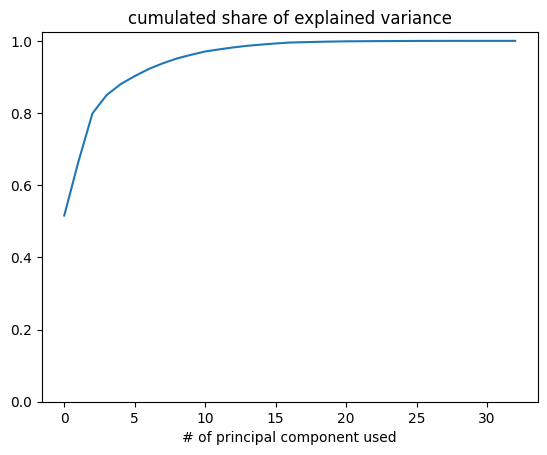

In [153]:
import matplotlib.pyplot as plt

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylim(ymin=0)
plt.title('cumulated share of explained variance')
plt.xlabel('# of principal component used');


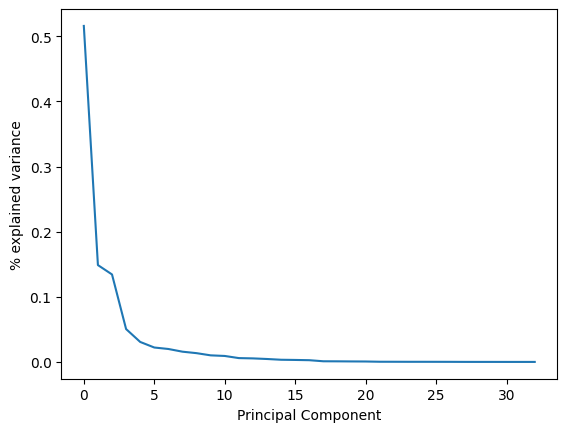

In [154]:

plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Principal Component'); plt.ylabel('% explained variance');


In [155]:
# Fit a PCA with only 3 components
pca3 = PCA(n_components=5).fit(X_fill)

# Project your data into 3 dimensions
X_proj3 = pd.DataFrame(pca3.fit_transform(X_fill), columns=['PC1', 'PC2', 'PC3', 'PC4','PC5'])

# We have "compressed" our dataset in 3D
X_proj3

,PC1,PC2,PC3,PC4,PC5
0,-0.300998,-0.028038,0.036373,0.118294,-0.039750
1,-0.255180,-0.025014,0.049559,0.083568,-0.008891
2,0.476046,-0.220173,0.055004,-0.016600,-0.002390
3,-0.234263,-0.052594,-0.025842,-0.025115,-0.000925
4,0.181153,0.188419,-0.093734,0.027206,-0.028493
...,...,...,...,...,...
9822,0.218197,0.239999,-0.061656,-0.104015,0.182900
9823,0.220121,0.215287,-0.129164,-0.065198,-0.146168
9824,-0.237467,-0.053089,-0.027327,-0.003611,0.000539
9825,-0.237467,-0.053089,-0.027326,-0.003610,0.000539


In [163]:
from sklearn.cluster import KMeans

# Fit K-means
km = KMeans(n_clusters=2)
km.fit(X_proj)

KMeans(n_clusters=2)

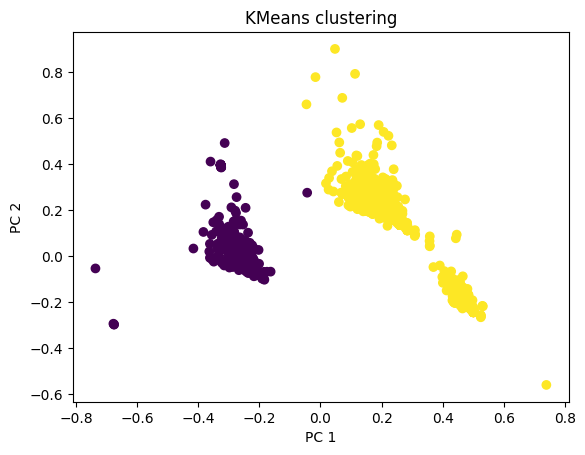

In [164]:
plt.scatter(X_proj.iloc[:,0], X_proj.iloc[:,1], c=km.labels_)
plt.title('KMeans clustering'); plt.xlabel('PC 1'); plt.ylabel('PC 2');

## Deep Learning

In [ ]:
model = Sequential()
model.add(layers.Dense(10, activation='relu', input_dim=100))
#model.add(...)
model.add(layers.Dense(8, activation='softmax'))

In [23]:
X_train_processed = preproc_baseline.fit_transform(X_train)

In [24]:
from tensorflow import keras
from tensorflow.keras import Model, Sequential, layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
model = Sequential()
model.add(layers.Dense(10, activation='relu', input_shape=X_train_processed.shape[1:]))
#model.add(...)
model.add(layers.Dense(8, activation='softmax'))